In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

from polar_mnist.io import get_train_loader, get_val_loader
from polar_mnist.model import CNN1D

## Train the Model

Load the train and validation datasets.

In [2]:
train = get_train_loader(batch_size=64, shuffle=True, num_workers=11)
val = get_val_loader(batch_size=64, num_workers=11)

Build and train the model.

In [3]:
model = CNN1D()

checkpoint_callback = ModelCheckpoint(
    "./checkpoints", 
    monitor="val_loss", 
    save_weights_only=True,
    filename="cnn1d-{epoch}-{val_loss:.2f}",
)
trainer = L.Trainer(max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(model, train, val)

model = CNN1D.load_from_checkpoint(checkpoint_callback.best_model_path).eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/az/code/mnist-cell/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/az/code/mnist-cell/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | feature_extractor | Sequential | 2.9 K  | train
1 | classifier        | Sequential | 132 K  | train
---------------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 938/938 [00:12<00:00, 73.51it/s, v_num=0, train_loss=1.460, val_loss=1.510, val_acc=0.948]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:12<00:00, 73.50it/s, v_num=0, train_loss=1.460, val_loss=1.510, val_acc=0.948]


## Evaluate the Model

Build a confusion matrix of predicted and observed digits.

In [6]:
confusion_matrix = torch.zeros(10, 10)
# with torch.no_grad():
for i, (imgs, labels) in enumerate(val):
    outputs = model(imgs.to(model.device))
    _, preds = torch.max(outputs, 1)
    for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

Plot the confusion matrix.

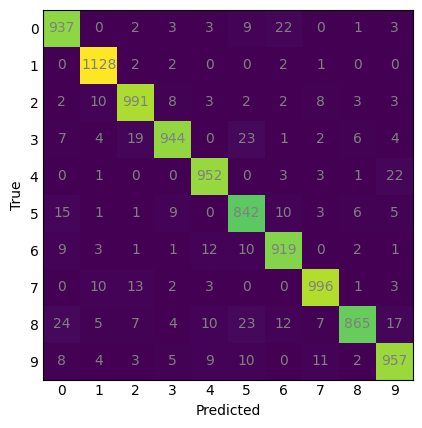

In [7]:
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap="viridis")

for (i, j), n in np.ndenumerate(confusion_matrix):
    ax.text(
        j, i, f"{n:.0f}", ha="center", va="center", color="grey", fontweight="normal"
    )

ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.tick_params(length=0)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.xaxis.set_ticks_position("bottom")